In [122]:
import numpy as np
import math
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.special import iv
from scipy.linalg import expm, block_diag
from scipy import integrate
from openfermion import fermi_hubbard, jordan_wigner, get_sparse_operator
from collections import Counter

from qiskit import QuantumCircuit, QuantumRegister
from qiskit import Aer, transpile
from qiskit.circuit import Parameter
#from qiskit.providers.fake_provider import FakeGuadalupe, FakeNairobi
#from qiskit.visualization import plot_histogram

from HA_utils import Assembly_ACDF, get_real_CDF, get_fh_matrix

import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def fh_evolution_trotter(N_sites, t, U, tau, j, step, to_gate=True):
    
    qr = QuantumRegister(2*N_sites,'qr')
    qc = QuantumCircuit(qr)
    
    for _ in range(step):
        
        ## Hopping terms 
        theta = tau*t*j/step
        
        for i in range(N_sites//2):
            qc.rxx(theta,2*i,2*i+1)
            qc.ryy(theta,2*i,2*i+1)

            qc.rxx(theta,2*i+N_sites,2*i+1+N_sites)
            qc.ryy(theta,2*i+N_sites,2*i+1+N_sites)
            
        for i in range((N_sites-1)//2):
            qc.rxx(theta,2*i+1,2*i+2)
            qc.ryy(theta,2*i+1,2*i+2)

            qc.rxx(theta,2*i+N_sites+1,2*i+2+N_sites)
            qc.ryy(theta,2*i+N_sites+1,2*i+2+N_sites)
        
        ## Potential
        gamma = tau*j*U/(2*step)
        
        for i in range(N_sites):
            qc.rzz(gamma,i,i+N_sites)
    return qc.to_gate() if to_gate else qc

def initial_state_prep(N_sites, initial_state_symmetry=True, to_gate=True):

    qr = QuantumRegister(2*N_sites,'q')
    qc = QuantumCircuit(qr)

    if initial_state_symmetry:
        qc.h(0)
        for i in range(N_sites):
            if i%2!=0:
                qc.x(i)
            else:
                qc.x(i+N_sites)

        qc.cnot(0,range(1,2*N_sites))

    else:
        for i in range(N_sites):
            if i%2!=0:
                qc.x(i)
            else:
                qc.x(i+N_sites)
        

    return qc.to_gate() if to_gate else qc

In [3]:
def get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=True,test_type='real'):

    qr = QuantumRegister(2*N_sites+2,'q')
    qc = QuantumCircuit(qr)

    qc.h([0,1])
    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)

    
    prep_gate = initial_state_prep(N_sites=N_sites,initial_state_symmetry=initial_state_symmetry)
    qc.append(prep_gate.control(), [0]+list(range(2,2*N_sites+2)))

    evolution_gate = fh_evolution_trotter(N_sites=N_sites, t=t, U=U, tau=tau, j=j, step=step)
    qc.append(evolution_gate,range(2,2*N_sites+2))

    prep_gate_conj = prep_gate.reverse_ops()
    qc.append(prep_gate_conj.control(), [1]+list(range(2,2*N_sites+2)))

    qc.h([0,1])

    qc.measure_all()

    return qc

In [29]:
def get_new_Hadamard_circuit_para(N_sites, theta_para, gamma_para, step, initial_state_symmetry=True,test_type='real'):

    def fh_evolution_para(N_sites, theta_para, gamma_para, step, to_gate=True):
    
        qr = QuantumRegister(2*N_sites,'qr')
        qc = QuantumCircuit(qr)
        
        for _ in range(step):
            
            ## Hopping terms 
            #theta = tau*t*j/step
            #theta = Parameter('theta')
            
            for i in range(N_sites//2):
                qc.rxx(theta_para,2*i,2*i+1)
                qc.ryy(theta_para,2*i,2*i+1)

                qc.rxx(theta_para,2*i+N_sites,2*i+1+N_sites)
                qc.ryy(theta_para,2*i+N_sites,2*i+1+N_sites)
                
            for i in range((N_sites-1)//2):
                qc.rxx(theta_para,2*i+1,2*i+2)
                qc.ryy(theta_para,2*i+1,2*i+2)

                qc.rxx(theta_para,2*i+N_sites+1,2*i+2+N_sites)
                qc.ryy(theta_para,2*i+N_sites+1,2*i+2+N_sites)
            
            ## Potential
            #gamma = tau*j*U/(2*step)
            #gamma = Parameter('gamma')
            
            for i in range(N_sites):
                qc.rzz(gamma_para,i,i+N_sites)
        return qc.to_gate() if to_gate else qc

    qr = QuantumRegister(2*N_sites+2,'q')
    qc = QuantumCircuit(qr)

    qc.h([0,1])
    if test_type=='real':
        pass
    elif test_type=='imag':
        qc.s(0)

    
    prep_gate = initial_state_prep(N_sites=N_sites,initial_state_symmetry=initial_state_symmetry)
    qc.append(prep_gate.control(), [0]+list(range(2,2*N_sites+2)))

    evolution_gate = fh_evolution_para(N_sites=N_sites, theta_para=theta_para, gamma_para=gamma_para, step=step)
    qc.append(evolution_gate,range(2,2*N_sites+2))

    prep_gate_conj = prep_gate.reverse_ops()
    qc.append(prep_gate_conj.control(), [1]+list(range(2,2*N_sites+2)))

    qc.h([0,1])

    qc.measure_all()

    return qc 

In [27]:
def get_new_Z(N_sites, t, U, tau, j, step, shots, initial_state_symmetry=True):

    qc_real = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=initial_state_symmetry, test_type='real')
    qc_imag = get_new_Hadamard_circuit(N_sites, t, U, tau, j, step, initial_state_symmetry=initial_state_symmetry, test_type='imag')
    backend=Aer.get_backend('qasm_simulator')

    #start=time.time()
    qc_real = transpile(qc_real,backend)
    qc_imag = transpile(qc_imag,backend)
    #end=time.time()
    #print('time transpile: ', end-start)
    job_real = backend.run(qc_real,shots=shots)
    job_imag = backend.run(qc_imag,shots=shots)
    
    counts_real = job_real.result().get_counts()
    counts_imag = job_imag.result().get_counts()

    p00, p01, p10, p11 = 0,0,0,0
    if ('0'*2*N_sites+'00') in counts_real.keys():
        p00 = counts_real['0'*2*N_sites+'00']/shots
    if ('0'*2*N_sites+'01') in counts_real.keys():
        p01 = counts_real['0'*2*N_sites+'01']/shots
    if ('0'*2*N_sites+'10') in counts_real.keys():
        p10 = counts_real['0'*2*N_sites+'10']/shots
    if ('0'*2*N_sites+'11') in counts_real.keys():
        p11 = counts_real['0'*2*N_sites+'11']/shots

    X = p00+p11-p01-p10

    p00, p01, p10, p11 = 0,0,0,0
    if ('0'*2*N_sites+'00') in counts_imag.keys():
        p00 = counts_imag['0'*2*N_sites+'00']/shots
    if ('0'*2*N_sites+'01') in counts_imag.keys():
        p01 = counts_imag['0'*2*N_sites+'01']/shots
    if ('0'*2*N_sites+'10') in counts_imag.keys():
        p10 = counts_imag['0'*2*N_sites+'10']/shots
    if ('0'*2*N_sites+'11') in counts_imag.keys():
        p11 = counts_imag['0'*2*N_sites+'11']/shots

    Y = p00+p11-p01-p10

    lambda_R = U/4*N_sites

    Z = 2*(X-1j*Y)*np.exp(-1j*lambda_R*j*tau)
    return Z

def get_shots_per_run(F_list, total_shots,type='sample'):

    F_list_abs = np.array([np.abs(ele) for ele in F_list])
    probs = F_list_abs/sum(F_list_abs)
    if type=='sample':
        sampling = np.random.choice(range(len(probs)), size=int(total_shots), p=probs)
        counter = Counter(sampling)

        shots_list = np.zeros(len(probs),dtype=int)
        for i in range(len(probs)):
            shots_list[i] = int(counter[i])
    elif type=='distribution':
        shots_list = np.round(total_shots*probs)
    return shots_list

def get_Z_list(d, N_sites, t, U, tau, step, shots_list, initial_state_symmetry=True): ## shots_per_run should be replaced
    
    #Z_list = [get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list) for j in range(d+1)]

    Z_list = np.zeros(d+1,dtype='complex')
    for j in range(d+1):
        if shots_list[j]:
            Z_list[j] = get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list[j],initial_state_symmetry=initial_state_symmetry)
    return Z_list


def get_Z_list_para(d, N_sites, t, U, tau, step, shots_list, initial_state_symmetry=True): ## shots_per_run should be replaced
    
    #Z_list = [get_new_Z(N_sites, t, U, tau, 2*j+1, step, shots=shots_list) for j in range(d+1)]
    theta = Parameter('theta')
    gamma = Parameter('gamma')
    circuit_para_real = get_new_Hadamard_circuit_para(N_sites=N_sites, theta_para=theta, gamma_para=gamma, step=step, initial_state_symmetry=initial_state_symmetry,test_type='real')
    circuit_para_imag = get_new_Hadamard_circuit_para(N_sites=N_sites, theta_para=theta, gamma_para=gamma, step=step, initial_state_symmetry=initial_state_symmetry,test_type='imag')
    backend=Aer.get_backend('qasm_simulator')

    circuit_real_transpiled = transpile(circuit_para_real,backend)
    circuit_imag_transpiled = transpile(circuit_para_imag,backend)
    Z_list = np.zeros(d+1,dtype='complex')
    for j in range(d+1):
        if shots_list[j]:
            shots = shots_list[j]
            theta_value = tau*t*(2*j+1)/step
            gamma_value = tau*U*(2*j+1)/(2*step)
            circuit_real_binded = circuit_real_transpiled.bind_parameters({theta:theta_value,gamma:gamma_value})
            circuit_imag_binded = circuit_imag_transpiled.bind_parameters({theta:theta_value,gamma:gamma_value})
            job_real = backend.run(circuit_real_binded,shots=shots)
            job_imag = backend.run(circuit_imag_binded,shots=shots)

            counts_real = job_real.result().get_counts()
            counts_imag = job_imag.result().get_counts()

            p00, p01, p10, p11 = 0,0,0,0
            if ('0'*2*N_sites+'00') in counts_real.keys():
                p00 = counts_real['0'*2*N_sites+'00']/shots
            if ('0'*2*N_sites+'01') in counts_real.keys():
                p01 = counts_real['0'*2*N_sites+'01']/shots
            if ('0'*2*N_sites+'10') in counts_real.keys():
                p10 = counts_real['0'*2*N_sites+'10']/shots
            if ('0'*2*N_sites+'11') in counts_real.keys():
                p11 = counts_real['0'*2*N_sites+'11']/shots

            X = p00+p11-p01-p10

            p00, p01, p10, p11 = 0,0,0,0
            if ('0'*2*N_sites+'00') in counts_imag.keys():
                p00 = counts_imag['0'*2*N_sites+'00']/shots
            if ('0'*2*N_sites+'01') in counts_imag.keys():
                p01 = counts_imag['0'*2*N_sites+'01']/shots
            if ('0'*2*N_sites+'10') in counts_imag.keys():
                p10 = counts_imag['0'*2*N_sites+'10']/shots
            if ('0'*2*N_sites+'11') in counts_imag.keys():
                p11 = counts_imag['0'*2*N_sites+'11']/shots

            Y = p00+p11-p01-p10

            lambda_R = U/4*N_sites

            Z = 2*(X-1j*Y)*np.exp(-1j*lambda_R*(2*j+1)*tau)
            Z_list[j] = Z

    return Z_list

## Number of shots

In [207]:
N_sites = 4
t = 1
U = 4
step = 100
#total_shots=1500
precision = 20000
initial_state_symmetry=True
total_shots_list = [1500, 2500, 5000, 10000]

#F_list_import = np.load('F_list/F_list_d2e3_lim2e3_delta4.npy')
F_list_import=np.load('F_list/F_list_d2e4_lim1e4.npy')
d = 20000


fh_matrix = get_fh_matrix(N_sites=N_sites, t=t, U=U)
tau = 3*pi/(4*np.linalg.norm(fh_matrix))


ACDF_list = []
for total_shots in total_shots_list:
    shots_list = get_shots_per_run(F_list=F_list_import,
                                total_shots=total_shots)

    # Z_list = get_Z_list(d=d, N_sites=N_sites, t=t, U=U,
    #                     tau=tau, step=step, shots_list=shots_list,
    #                     initial_state_symmetry=initial_state_symmetry)
    
    Z_list = get_Z_list_para(d=d, N_sites=N_sites, t=t, U=U, tau=tau, step=step,
                             shots_list=shots_list, initial_state_symmetry=initial_state_symmetry)

    ACDF = Assembly_ACDF(Z_list=Z_list, F_list=F_list_import, precision=precision)
    ACDF_list.append(ACDF)

CDF = get_real_CDF(N_sites=N_sites,t=t,U=U,tau=tau,initial_state_symmetry=initial_state_symmetry,precision=precision)

/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


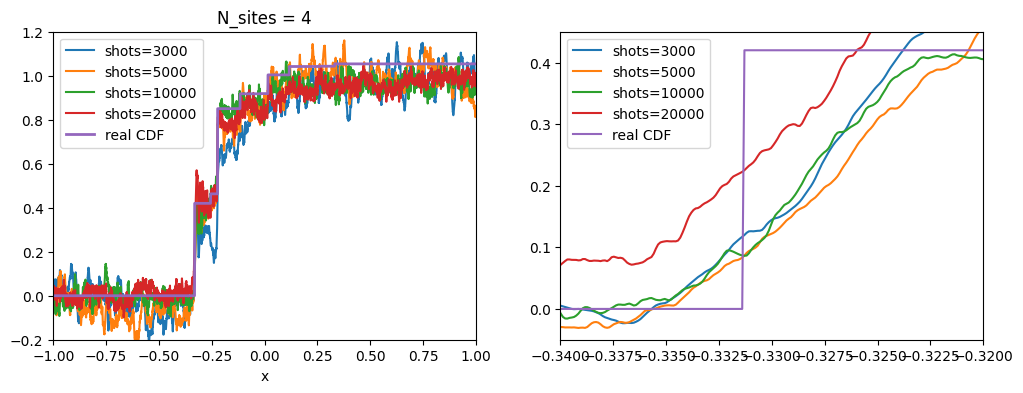

In [208]:
x_list = np.linspace(-pi/3,pi/3,precision)
fig, ax = plt.subplots(1,2,figsize=(12,4))

for i in range(len(total_shots_list)):
    ax[0].plot(x_list,ACDF_list[i],label='shots='+str(total_shots_list[i]*2))
ax[0].plot(x_list, CDF ,label='real CDF',linewidth=2)
ax[0].legend()
ax[0].set_xlabel('x')
ax[0].set_xlim([-1,1])
ax[0].set_ylim([-0.2,1.2])
ax[0].set_title('N_sites = '+str(N_sites))

for i in range(len(total_shots_list)):
    ax[1].plot(x_list,ACDF_list[i],label='shots='+str(total_shots_list[i]*2))
ax[1].plot(x_list, CDF,label='real CDF')
ax[1].set_xlim([-0.34,-0.32])
# ax[1].hlines(.21, -0.34, -0.32,linestyles='dashdot')
# ax[1].vlines(-0.3308, -1, 0.21,linestyles='dashed',label='-0.3308')
# ax[1].vlines(-0.33135, -1, 0,linestyles='dashed',colors='orange')
ax[1].legend()
#ax[1].set_xlim([-0.11,-0.08])
#ax[1].vlines(-0.0964,-1,0)
#ax[1].vlines(-0.1012,-1,0,linestyles='dashed',colors='orange',label='-.10093')
#ax[1].vlines(-0.1005,-1,0.18,linestyles='dashed',label='-.1005')
#ax[1].hlines(0.177,-0.11,0,linestyles='dashdot')
#ax[1].set_xticks([-.34,-.33135,-.32])
#ax[1].set_xticks([-.11,-.08])
#ax[1].text(.01,.01,'-0.3313')
ax[1].set_ylim([-0.05,0.45])
#ax[1].set_xlabel('x')
ax[1].legend()


# Trotterization Step

In [209]:
N_sites = 4
t = 1
U = 4
#step = 100
total_shots=5000
precision = 20000
initial_state_symmetry=True
step_list = [1, 10, 50, 100]

#F_list_import = np.load('F_list/F_list_d2e3_lim2e3_delta4.npy')
F_list_import=np.load('F_list/F_list_d2e4_lim1e4.npy')
d = 20000


fh_matrix = get_fh_matrix(N_sites=N_sites, t=t, U=U)
tau = 3*pi/(4*np.linalg.norm(fh_matrix))


ACDF_list = []
for step in step_list:
    shots_list = get_shots_per_run(F_list=F_list_import,
                                total_shots=total_shots)

    # Z_list = get_Z_list(d=d, N_sites=N_sites, t=t, U=U,
    #                     tau=tau, step=step, shots_list=shots_list,
    #                     initial_state_symmetry=initial_state_symmetry)
    
    Z_list = get_Z_list_para(d=d, N_sites=N_sites, t=t, U=U, tau=tau, step=step,
                             shots_list=shots_list, initial_state_symmetry=initial_state_symmetry)

    ACDF = Assembly_ACDF(Z_list=Z_list, F_list=F_list_import, precision=precision)
    ACDF_list.append(ACDF)

CDF = get_real_CDF(N_sites=N_sites,t=t,U=U,tau=tau,initial_state_symmetry=initial_state_symmetry,precision=precision)

/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/dranz/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


/Users/dranz/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


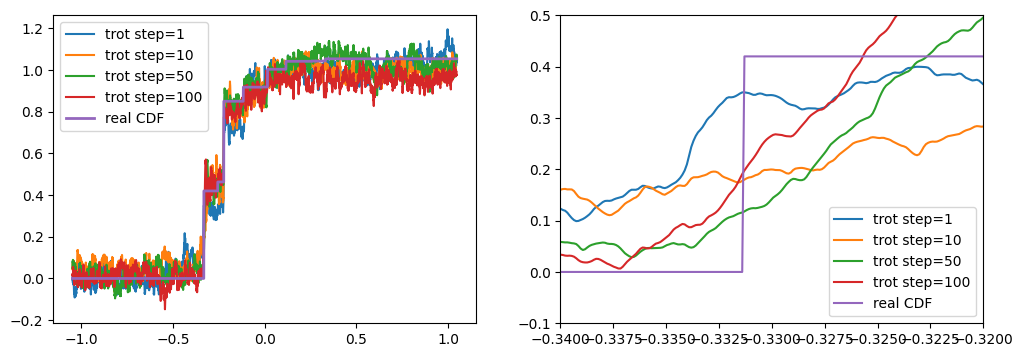

In [216]:
x_list = np.linspace(-pi/3,pi/3,precision)
fig, ax = plt.subplots(1,2,figsize=(12,4))

for i in range(len(step_list)):
    ax[0].plot(x_list,ACDF_list[i],label='trot step='+str(step_list[i]))
ax[0].plot(x_list, CDF ,label='real CDF',linewidth=2)
ax[0].legend()

for i in range(len(total_shots_list)):
    ax[1].plot(x_list,ACDF_list[i],label='trot step='+str(step_list[i]))
ax[1].plot(x_list, CDF,label='real CDF')
ax[1].set_xlim([-0.34,-0.32])
ax[1].set_ylim([-0.1,0.5])
ax[1].legend()
